# Lab: Tree-Based Methods
We import some of our usual libraries at this top
level.

In [7]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots 
import matplotlib.pyplot as plt
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS


We also  collect the new imports
needed for this lab.

In [8]:
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
from ISLP.bart import BART


Decision trees involve segmenting the predictor space into a number of simple regions $j$. In order to make a prediction for a given observation, we typically use the mean of the training observations in the region $j$ to which it belongs. Since the set of splitting rules used to segment the predictor space can be summarized in a tree, these types of approaches are known as decision tree methods.



## Fitting Classification Trees

We first use classification trees to analyze the  `Carseats`  data set.
In these data, `Sales` is a continuous variable, and so we begin
by recoding it as a binary variable. We use the `where()` 
function to create a variable, called `High`, which takes on a
value of `Yes` if the `Sales` variable exceeds 8, and takes
on a value of `No` otherwise.

In [3]:
Carseats = load_data('Carseats')
High = np.where(Carseats.Sales > 8,
                "Yes",
                "No")


We now use `DecisionTreeClassifier()`  to fit a classification tree in
order to predict `High` using all variables but `Sales`.
To do so, we must form a model matrix leaving `Sales` out.

In [4]:
model = MS(Carseats.columns.drop('Sales'), intercept=False)
D = model.fit_transform(Carseats)
feature_names = list(D.columns)
X = np.asarray(D)


We have converted `D` from a data frame to an array `X`, which is needed in some of the analysis below. We also need the `feature_names` for annotating our plots later.

There are several options needed to specify the  classifier,
such as `max_depth` (how deep to grow the tree), `min_samples_split`
(minimum number of observations in a node to be eligible for splitting)
and `criterion` (whether to use Gini or cross-entropy as the split criterion).
We also set `random_state` for reproducibility; ties in the split criterion are broken at random.

In [5]:
clf = DTC(criterion='entropy',
          max_depth=3,
          random_state=0)        
clf.fit(X, High)


DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

There is a more
natural way to handle qualitative features when building a decision
tree, that does not require creating manually dummy variables; each split amounts to partitioning the levels into two groups.
However, 
the `sklearn` implementation of decision trees does not take
advantage of this approach; instead it simply treats the one-hot-encoded levels as separate variables.

In [6]:
accuracy_score(High, clf.predict(X))


0.79

With only the default arguments, the training error rate is
21%.
For classification trees, we can
access the value of the deviance using `log_loss()`,
\begin{equation*}
\begin{split}
-2 \sum_m \sum_k n_{mk} \log \hat{p}_{mk},
\end{split}
\end{equation*}
where $n_{mk}$ is the number of observations in the $m$th terminal
node that belong to the $k$th class.

In [7]:
resid_dev = np.sum(log_loss(High, clf.predict_proba(X)))
resid_dev


0.47106470626493574

A small deviance indicates atree that provides a good fit to the (training) data.
 
One of the most attractive properties of trees is that they can be graphically displayed. Here we use the `plot()`  function to display the tree structure.

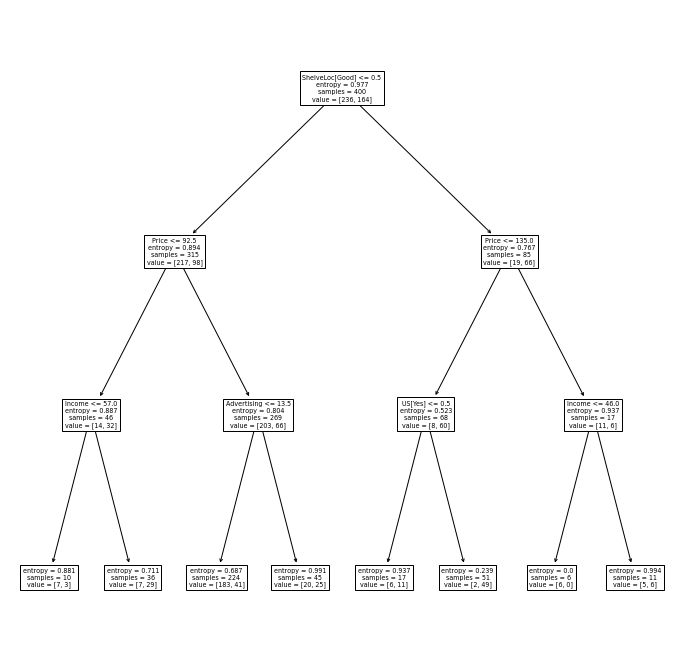

In [8]:
ax = subplots(figsize=(12,12))[1]
plot_tree(clf,
          feature_names=feature_names,
          ax=ax);


The most important indicator of `Sales` appears to be `ShelveLoc`.

We can see a text representation of the tree using
`export_text()`, which displays the split
criterion (e.g. `Price <= 92.5`) for each branch.
For leaf nodes it shows the overall prediction  
(`Yes` or `No`). 
 We can also see the number of observations in that
leaf that take on values of `Yes` and `No` by specifying  `show_weights=True`.

In [9]:
print(export_text(clf,
                  feature_names=feature_names,
                  show_weights=True))


|--- ShelveLoc[Good] <= 0.50
|   |--- Price <= 92.50
|   |   |--- Income <= 57.00
|   |   |   |--- weights: [7.00, 3.00] class: No
|   |   |--- Income >  57.00
|   |   |   |--- weights: [7.00, 29.00] class: Yes
|   |--- Price >  92.50
|   |   |--- Advertising <= 13.50
|   |   |   |--- weights: [183.00, 41.00] class: No
|   |   |--- Advertising >  13.50
|   |   |   |--- weights: [20.00, 25.00] class: Yes
|--- ShelveLoc[Good] >  0.50
|   |--- Price <= 135.00
|   |   |--- US[Yes] <= 0.50
|   |   |   |--- weights: [6.00, 11.00] class: Yes
|   |   |--- US[Yes] >  0.50
|   |   |   |--- weights: [2.00, 49.00] class: Yes
|   |--- Price >  135.00
|   |   |--- Income <= 46.00
|   |   |   |--- weights: [6.00, 0.00] class: No
|   |   |--- Income >  46.00
|   |   |   |--- weights: [5.00, 6.00] class: Yes



In order to properly evaluate the performance of a classification tree
on these data, we must **estimate the test error** rather than simply
computing the training error. 

To do so, we 1) split the observations into a training set and a test set; 2) build the tree using the training set; 3) and evaluate its performance on the test data. This approach leads to correct predictions
for 68.5% of the locations in the test data set.

In [10]:
validation = skm.ShuffleSplit(n_splits=1,
                              test_size=200,
                              random_state=0)
results = skm.cross_validate(clf,
                             D,
                             High,
                             cv=validation)
results['test_score']


array([0.685])

The process described above may produce good predictions on the training set, but is likely to overfit the data, leading to poor test set performance. This is because the resulting tree might be too complex. A smaller tree with fewer splits might lead to lower variance and better interpretation at the cost of a little bias. We will prune this tree.

Next, we consider whether pruning the tree might lead to improved
classification performance. We first split the data into a training and
test set. We will use cross-validation to prune the tree on the training
set, and then evaluate the performance of the pruned tree on the test
set.

In [11]:
(X_train,
 X_test,
 High_train,
 High_test) = skm.train_test_split(X,
                                   High,
                                   test_size=0.5,
                                   random_state=0)
                                   

We first refit the full tree on the training set; here we do not set a `max_depth` parameter, since we will learn that through cross-validation.


In [12]:
clf = DTC(criterion='entropy', random_state=0)
clf.fit(X_train, High_train)
accuracy_score(High_test, clf.predict(X_test))


0.735

Next we use the `cost_complexity_pruning_path()` method of
`clf` to extract cost-complexity values. 

In [13]:
ccp_path = clf.cost_complexity_pruning_path(X_train, High_train)
kfold = skm.KFold(10,
                  random_state=1,
                  shuffle=True)


This yields a set of impurities and $\alpha$ values
from which we can extract an optimal one by cross-validation.

In [14]:
grid = skm.GridSearchCV(clf,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy')
grid.fit(X_train, High_train)
grid.best_score_


0.685

Let’s take a look at the pruned true.

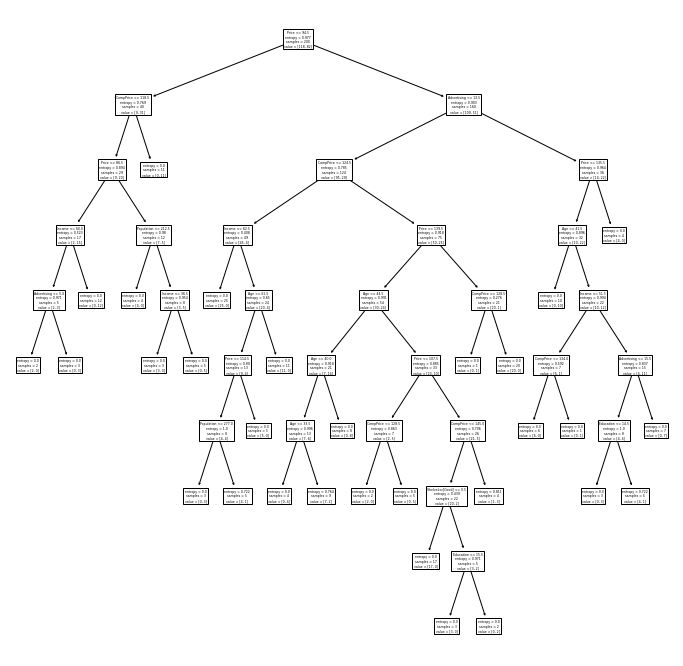

In [15]:
ax = subplots(figsize=(12, 12))[1]
best_ = grid.best_estimator_
plot_tree(best_,
          feature_names=feature_names,
          ax=ax);


This is quite a bushy tree. We could count the leaves, or query
`best_` instead.

In [16]:
best_.tree_.n_leaves


30

The tree with 30 terminal
nodes results in the lowest cross-validation error rate, with an accuracy of
68.5%. How well does this pruned tree perform on the test data set? Once
again, we apply the `predict()`  function.

In [17]:
print(accuracy_score(High_test,
                     best_.predict(X_test)))
confusion = confusion_table(best_.predict(X_test),
                            High_test)
confusion


0.72


Truth,No,Yes
Predicted,,
No,94,32
Yes,24,50


Now 72.0% of the test observations are correctly classified, which is slightly worse than the error for the full tree (with 35 leaves). So cross-validation has not helped us much here; it only pruned off 5 leaves, at a cost of a slightly worse error. These results would change if we were to change the random number seeds above; even though cross-validation gives an unbiased approach to model selection, it does have variance.

  

## Fitting Regression Trees
For this session we will consider the  `Boston`  data set. As in past lab, it consists in individual level data of house in Boston metropolitan area. We are interested in predicting the houses `Median value` (Median value of owner-occupied homes in USD 1000s).

The steps are similar to those for classification trees.

In [3]:
Boston = load_data("Boston")
Boston.head()


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


Let's look at how the per capita crime rate `crim`, the avg number of rooms per dwelling `rm`, and the nitric oxides concentration (ppm 10)  `nox`.

In [42]:
# Get Features
features = ['crim', 'nox', 'rm']
X = Boston[features].values
y = Boston.medv.values

Text(0.5, 0, 'Median price')

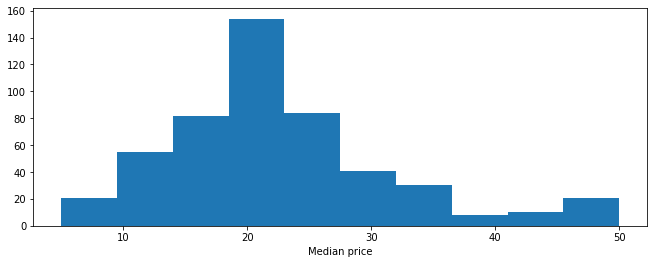

In [38]:
fig, (ax1) = plt.subplots(1, figsize=(11,4))

# Plot salary distribution
ax1.hist(y)
ax1.set_xlabel('Median price')

Let’s first have a look at one tree. We fit a regression three with 2 nodes

In [43]:
# Fit regression tree
tree = DTR(max_leaf_nodes=3)
tree.fit(X, y)

DecisionTreeRegressor(max_leaf_nodes=3)

In [44]:
DTR(max_leaf_nodes=3)

DecisionTreeRegressor(max_leaf_nodes=3)

Let's plot the results, remember that the main advantage of using trees is its interpretability.

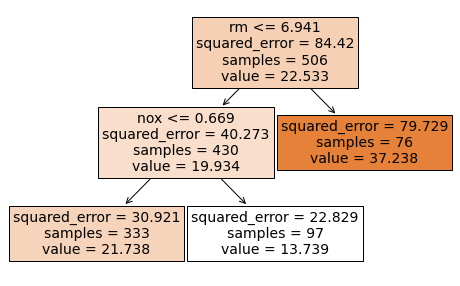

In [45]:
fig, ax = plt.subplots(figsize=(8, 5))  # Adjust the figsize to your preference
ax.set_title('Decision tree');

# Plot tree
plot_tree(tree, filled=True, feature_names=features, fontsize=14, ax=ax);

The tree is simply a series of splitting rules, beginning at the top of the tree. The first split assigns observations having `rm`>6.941 to the right branch. The predicted median value for these houses is the mean response value for the houses in the data with `rm`>6.941. We can see that for these houses, the median  value is 37.238 thousands of dollars.  

Houses with `lstat`<=9.725 are allocated to the left branch, and group further by `nox`.

Overall, the tree segments the houses into three regions: 
1. Houses who have more than 6.941 rooms.
2. Houses who have less than 6.941 rooms and located in neighborhood with nitric oxides concentration less than 0.669 ppm
3. Houses who have less than 6.941 rooms and located in neighborhood with nitric oxides concentration more than 0.669 ppm



We can visualize the three distincts regiosn in the following 2D graphs

In [68]:
def make_region():
    
    # Init
    Boston.plot('rm', 'nox', kind='scatter', color='orange', figsize=(7,6))
    plt.xlim(2,10); plt.ylim(ymin=0.2);
    plt.xticks([2, 6.9, 10]); plt.yticks([0.2, 0.669, 0.8]);

    # Split lines
    plt.vlines(6.9, ymin=0, ymax=10, color='g')
    plt.hlines(0.669, xmin=0, xmax=6.941, color='g')
     # Regions
    plt.annotate('R1', xy=(8,0.5), fontsize='xx-large')
    plt.annotate('R2', xy=(4,0.8), fontsize='xx-large')
    plt.annotate('R3', xy=(3,0.3), fontsize='xx-large');

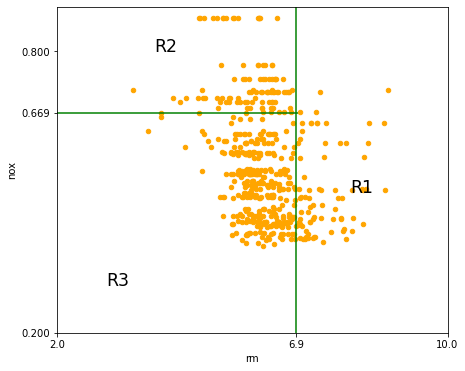

In [69]:
make_region()

We may **interpret** the above regression tree as follows: number of rooms is the most important factor in determining house value, and house with less rooms have lower value than those with more rooms. Given that a house has more rooms, the nox concentration in the neighborhood seems to play little role in its value. But among houses who have fewer room, the nox concentration in the neighborhood does affect its value, and houses in more polluted neighborhood have a lower value.



### Building a tree
Two main steps: 
1. Divide the predictor space into $J$ distinct and non-overlapping regions, $R_{1}, \dot, R_{J}$ 
2. For every observation falling into the region $j$, we assign the mean of the outcome for the training observation in that region.

The objective is to minimize the SSR across the different regions: 
 $$ \sum_{j=1}^{J} \sum_{i \in R_{j}}\left(y_{i}-\hat{y}{R{j}}\right)^{2} $$
but as often its infeasible to consider every partition of the feature space into $J$ regions. 

Therefore, we follow a **top-down greedy** approach: *recursive biniary splitting*. 
- Why top-downn? It is because it starts ah the top of the tree (when all observations are in a single and unique region), and then successively divides the space. 
- Why greedy? Because at each step, the best split is made at the particular step.

In practice: 
1. Select the predictor $X_{j}$
2. Select a cutpoint $s$ such that the split leads to the highest possible reduction in RSS
3. Repeat for all predictors 
4. Pick the predictor and cutpoint leading to the tree with the lowest RSS
5. When to stop? once we meet a decision criteria: for instance number of observations per node, size of the tree.

We build a Node class to play around with trees

In [70]:
class Node:
    """
    Class used to represent nodes in a Regression Tree
    
    Attributes
    ----------
    x : np.array
        independent variables
    y : np.array
        dependent variables
    idxs : np.array
        indexes fo x and y for current node
    depth : int
        depth of the sub-tree (default 5)

    Methods
    -------
    find_next_nodes(self)
        Keep growing the tree
        
    find_best_split(self)
        Find the best split
        
    split(self)
        Split the tree
    """
    
    def __init__(self, x, y, idxs, depth=5):
        """Initialize node"""
        self.x = x
        self.y = y
        self.idxs = idxs 
        self.depth = depth
        self.get_next_nodes()

    def get_next_nodes(self):
        """If the node is not terminal, get further splits"""
        if self.is_last_leaf: return 
        self.find_best_split()       
        self.split()             
        
    def find_best_split(self):
        """Loop over variables and their values to find the best split"""
        best_score = float('inf')
        # Loop over variables
        for col in range(self.x.shape[1]):
            x = self.x[self.idxs, col]
            # Loop over all splits
            for s in np.unique(x):
                lhs = x <= s
                rhs = x > s
                curr_score = self.get_score(lhs, rhs)
                # If best score, save it 
                if curr_score < best_score: 
                    best_score = curr_score
                    self.split_col = col
                    self.split_val = s
        return self
    
    def get_score(self, lhs, rhs):
        """Get score of a given split"""
        y = self.y[self.idxs]
        lhs_mse = self.get_mse(y[lhs])
        rhs_mse = self.get_mse(y[rhs])
        return lhs_mse * lhs.sum() + rhs_mse * rhs.sum()
        
    def get_mse(self, y): return np.mean((y-np.mean(y))**2)
    
    def split(self): 
        """Split a node into 2 sub-nodes (recursive)"""
        x = self.x[self.idxs, self.split_col]
        lhs = x <= self.split_val
        rhs = x > self.split_val
        self.lhs = Node(self.x, self.y, self.idxs[lhs], self.depth-1)
        self.rhs = Node(self.x, self.y, self.idxs[rhs], self.depth-1)
        to_print = (self.depth, self.split_col, self.split_val, sum(lhs), sum(rhs))
        print('Split on layer %.0f: var%1.0f = %.4f (%.0f/%.0f)' % to_print)
        return self
    
    @property
    def is_last_leaf(self): return self.depth<=1

In [78]:
# Init first node
tree1 = Node(X, y, np.arange(len(y)), 1)

# Documentation (always comment and document your code!)
print(tree1.__doc__)


    Class used to represent nodes in a Regression Tree
    
    Attributes
    ----------
    x : np.array
        independent variables
    y : np.array
        dependent variables
    idxs : np.array
        indexes fo x and y for current node
    depth : int
        depth of the sub-tree (default 5)

    Methods
    -------
    find_next_nodes(self)
        Keep growing the tree
        
    find_best_split(self)
        Find the best split
        
    split(self)
        Split the tree
    


In [79]:
# Inspect the class and its properties
dir(tree1)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'depth',
 'find_best_split',
 'get_mse',
 'get_next_nodes',
 'get_score',
 'idxs',
 'is_last_leaf',
 'split',
 'x',
 'y']

In [80]:
# Get info about its depth and the number of observation in it
print('Tree of depth %.0f with %.0f observations' % (tree1.depth, len(tree1.idxs)))

Tree of depth 1 with 506 observations


That is normal because the tree is just a single node so far. We can check if its the terminal node

In [81]:
tree1.is_last_leaf

True

Ok, let's move on and find the first best split

In [82]:
# Find best split
tree1.find_best_split()
print('Split at var%1.0f = %.4f' % (tree1.split_col, tree1.split_val))

Split at var2 = 6.9390


It has selected the first variable at value 6.93, we can call the `split` function to see how many observation per leaf the split generates

In [84]:
tree1.split();

Split on layer 1: var2 = 6.9390 (430/76)


Now we can even compute  deeper trees

In [85]:
# Check depth-3 tree
tree3 = Node(X, y, np.arange(len(y)), 3)

Split on layer 2: var1 = 0.6680 (333/97)
Split on layer 2: var2 = 7.4200 (46/30)
Split on layer 3: var2 = 6.9390 (430/76)


### Pruning

The process described above may produce good predictions on the training set, but is likely to overfit the data, leading to poor test set performance. This is because the resulting tree might be too complex. A smaller tree with fewer splits might lead to lower variance and better interpretation at the cost of a little bias.

In [90]:
# Compute the same tree as above but with 5 leaves 
overfit_tree = DTR(max_leaf_nodes=5).fit(X, y)

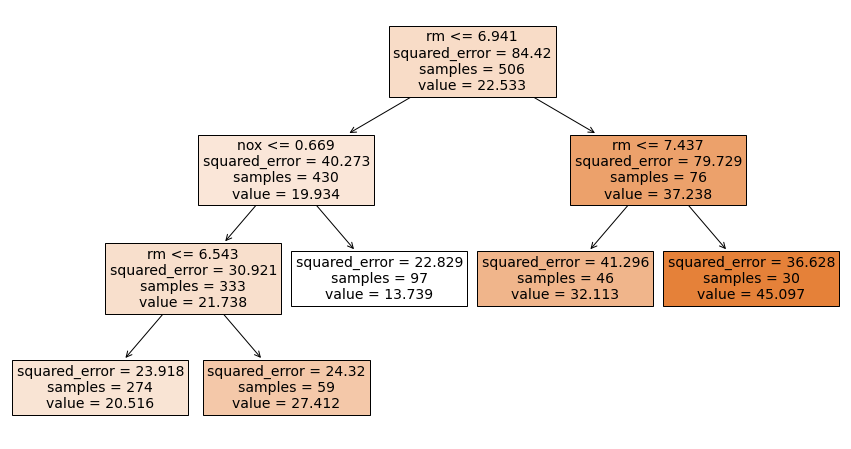

In [95]:
# Plot tree
fig, ax = plt.subplots(figsize=(15, 8))  # Adjust the figsize to your preference
plot_tree(overfit_tree, filled=True, feature_names=features, fontsize=14, ax=ax);

The split on the far right is predicting a very high `medv` (45.097) for houses with more than 7.437 rooms. But its prediction is based on a small sample (30). This can be see as a sign of potential overfitting. 

An alternative is to set a minimum number of observation per leaf. 

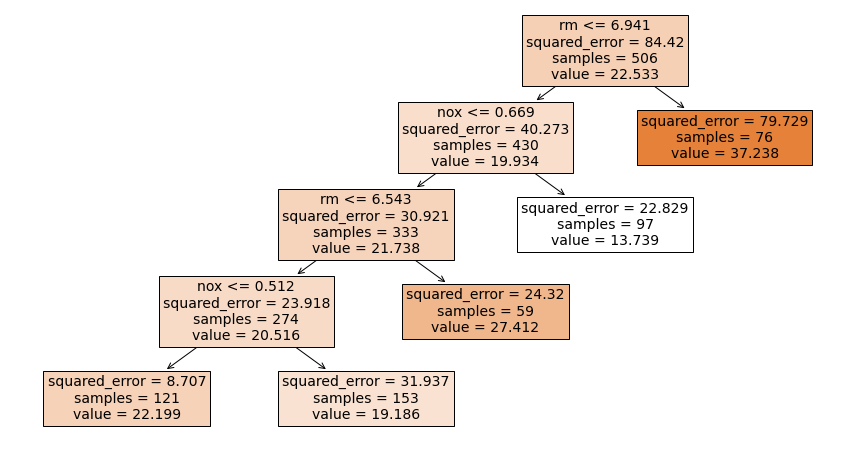

In [97]:
# Compute tree
no_overfit_tree = DTR(max_leaf_nodes=5, min_samples_leaf=50).fit(X, y)

# Plot tree
fig, ax = plt.subplots(figsize=(15, 8))  # Adjust the figsize to your preference
plot_tree(no_overfit_tree, filled=True, feature_names=features, fontsize=14, ax=ax);

Another possible alternative to the process described above is to build the tree only so long as the decrease in the RSS due to each split exceeds some (high) threshold.

This strategy will result in smaller trees, but is too short-sighted since a seemingly worthless split early on in the tree might be followed by a very good split—that is, a split that leads to a large reduction in RSS later on.

We can use cross-validation to pick the optimal tree length but let's move to more powerfull tools.

## Bagging and Random Forests

Bagging, random forests, and boosting use trees as building blocks to construct more powerful prediction models.

### Bagging

Remember the main problem of decision trees? It has high variance. Bootstrap aggregation, or bagging, reduce the variance of a statistical learning method.

The main intuition behind bagging is that averaging a set of random variables has loher variance than any single of them.

Indeed bagging consists in taking many boostrap sample from the population, build a separate prediction model using each training set $$  \hat{f_{bag}}(x) = \dfrac{1}{B}\sum_{b=1}^{B} \hat{f}^{*b}(x)$$  and average the resulting predictions. 

We assess its performance using the **out-of-bag observations** ($\approx$ 1/3 of the sample) to predict $y$ for the $i^th$ observation using each of the trees in which it was OOB, yields to $B/3$ predictions for the $i^th$ obs. Then, we average each of them to compute the the out-of-bag error (i.e., test MSE).



Here we apply bagging and random forests to the `Boston` data, using
the `RandomForestRegressor()` from the `sklearn.ensemble` package. Recall
that bagging is simply a special case of a random forest with
$m=p$. Therefore, the `RandomForestRegressor()`  function can be used to
perform both bagging and random forests. We start with bagging.

First, we split the data into training and test sets, using 30% of the data for the test set. Ch



In [103]:
Boston = load_data("Boston")
model = MS(Boston.columns.drop('medv'), intercept=False)
D = model.fit_transform(Boston)
feature_names = list(D.columns)
X = np.asarray(D)

(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                Boston['medv'],
                                test_size=0.3,
                                random_state=0)

In [104]:
bag_boston = RF(max_features=X_train.shape[1], random_state=0)
bag_boston.fit(X_train, y_train)


RandomForestRegressor(max_features=12, random_state=0)

The argument `max_features` indicates that all 12 predictors should
be considered for each split of the tree --- in other words, that
bagging should be done.  How well does this bagged model perform on
the test set?

14.634700151315787

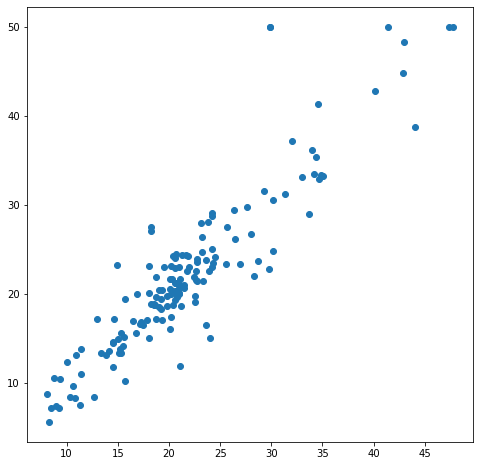

In [105]:
ax = subplots(figsize=(8,8))[1]
y_hat_bag = bag_boston.predict(X_test)
ax.scatter(y_hat_bag, y_test)
np.mean((y_test - y_hat_bag)**2)


The test set MSE associated with the bagged regression tree is
14.63, about half that obtained using an optimally-pruned single
tree.  We could change the number of trees grown from the default of
100 by
using the `n_estimators` argument:

In [106]:
bag_boston = RF(max_features=X_train.shape[1],
                n_estimators=500,
                random_state=0).fit(X_train, y_train)
y_hat_bag = bag_boston.predict(X_test)
np.mean((y_test - y_hat_bag)**2)

14.605662565263161

There is not much change. Bagging and random forests cannot overfit by
increasing the number of trees, but can underfit if the number is too small.

#### Random forest

Random Forest: randomly restricts which splits of the tree are allowed at each node. At each split, only a random subsample of covariates $m$ is considered. Then, one covariate is choose among $m$. A fresh sample is drawn at each split. 

In growing a random forest, at each split in the tree, the algorithm is not even allowed to consider all the available predictors. Why? Suppose that there is one very strong covariate in the data set, along with a number of other moderately or weakly strong covariates. Then, most or all of the trees will use this strong predictor in the top split. Therefore, all of the bagged trees will look quite similar to each other and their predictions will be highly correlated. Why does it matter? 

The reason is that averaging many highly correlated random variables does not lead to as large of a reduction in variance as averaging many uncorrelated random variables. This means that bagging will not lead to a substantial reduction in variance over a single tree in this setting.

Random forests overcome this problem: it forces **each split to consider only a subset of the predictors**.


Growing a random forest proceeds in exactly the same way, except that
we use a smaller value of the `max_features` argument. By default,
`RandomForestRegressor()`  uses $p$ variables when building a random
forest of regression trees (i.e. it defaults to bagging), and `RandomForestClassifier()` uses
$\sqrt{p}$ variables when building a
random forest of classification trees. Here we use `max_features=6`.

In [107]:
RF_boston = RF(max_features=6,
               random_state=0).fit(X_train, y_train)
y_hat_RF = RF_boston.predict(X_test)
np.mean((y_test - y_hat_RF)**2)


20.04276446710527

The test set MSE is 20.04;
this indicates that random forests did somewhat worse than bagging
in this case. Extracting the `feature_importances_` values from the fitted model, we can view the
importance of each variable.

In [108]:
feature_imp = pd.DataFrame(
    {'importance':RF_boston.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
lstat,0.356203
rm,0.332163
ptratio,0.067270
crim,0.055404
indus,0.053851
dis,0.041582
nox,0.035225
tax,0.025355
age,0.021506
rad,0.004784


We can have a look at the importance of each feature.

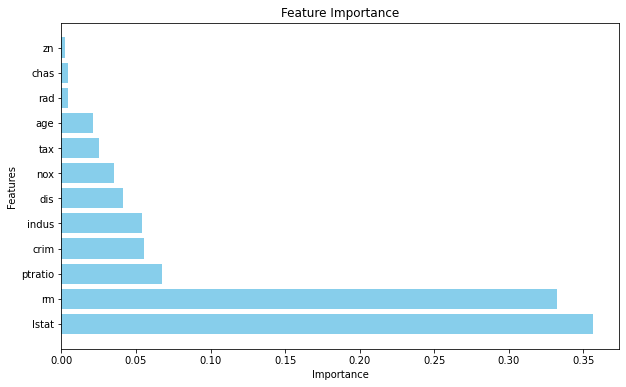

In [121]:
# Sort the feature importance values in descending order
feature_imp_sorted = feature_imp.sort_values(by='importance', ascending=False)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(feature_imp_sorted.index, feature_imp_sorted['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

 This
is a relative measure of the total decrease in node impurity that results from
splits over that variable, averaged over all trees.

The results indicate that across all of the trees considered in the
random forest, the wealth level of the community (`lstat`) and the
house size (`rm`) are by far the two most important variables.

  

## Boosting

Boosting works similarly to bagging, except that the trees are grown sequentially: each tree is grown using information from previously grown trees. Boosting does not involve bootstrap sampling; instead each tree is fit on a modified version of the original data set.

Intuition is as follows:
 * Given the current model, we fit a decision tree to the residuals from the model: we fit a tree using the current residuals, rather than the outcome 
, as the response. 
 * Add this new decision tree into the fitted function in order to update the residuals. Each of these trees can be rather small, with just a few terminal nodes, determined by the parameter  in the algorithm. By doing so, we slowly improve  in areas where it does not perform well. The shrinkage parameter $\lambda$ slows the process down even further, allowing more and different shaped trees to shrink the residuals. 
    
In general, statistical learning approaches that learn slowly tend to perform well.

Boosting has three tuning parameters:

1. The number of trees $B$
2. The shrinkage parameter $\lambda$: controls the rate at which boosting learns
3. The number of splits in each tree $d$: the complexity of the boosted ensemble.  Often $d = 1$ works well, in which case each tree is a stump, consisting of a single split.

Here we use `GradientBoostingRegressor()` from `sklearn.ensemble`
to fit boosted regression trees to the `Boston` data
set. For classification we would  use `GradientBoostingClassifier()`.
The argument `n_estimators=5000`
indicates that we want 5000 trees, and the option
`max_depth=3` limits the depth of each tree. The
argument `learning_rate` is the $\lambda$
mentioned earlier in the description of boosting.

In [112]:
boost_boston = GBR(n_estimators=5000,
                   learning_rate=0.001,
                   max_depth=3,
                   random_state=0)
boost_boston.fit(X_train, y_train)


GradientBoostingRegressor(learning_rate=0.001, n_estimators=5000,
                          random_state=0)

We can see how the training error decreases with the `train_score_` attribute.
To get an idea of how the test error decreases we can use the
`staged_predict()` method to get the predicted values along the path.

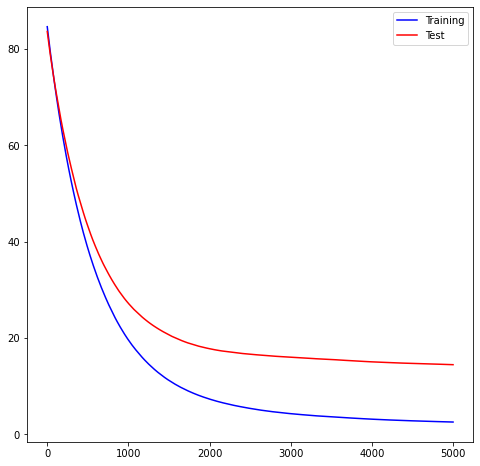

In [113]:
test_error = np.zeros_like(boost_boston.train_score_)
for idx, y_ in enumerate(boost_boston.staged_predict(X_test)):
   test_error[idx] = np.mean((y_test - y_)**2)

plot_idx = np.arange(boost_boston.train_score_.shape[0])
ax = subplots(figsize=(8,8))[1]
ax.plot(plot_idx,
        boost_boston.train_score_,
        'b',
        label='Training')
ax.plot(plot_idx,
        test_error,
        'r',
        label='Test')
ax.legend();


We now use the boosted model to predict `medv` on the test set:

In [114]:
y_hat_boost = boost_boston.predict(X_test);
np.mean((y_test - y_hat_boost)**2)


14.481405918831591

 The test MSE obtained is 14.48,
similar to the test MSE for bagging. If we want to, we can
perform boosting with a different value of the shrinkage parameter
$\lambda$. The default value is 0.001, but
this is easily modified.  Here we take $\lambda=0.2$.

In [115]:
boost_boston = GBR(n_estimators=5000,
                   learning_rate=0.2,
                   max_depth=3,
                   random_state=0)
boost_boston.fit(X_train,
                 y_train)
y_hat_boost = boost_boston.predict(X_test);
np.mean((y_test - y_hat_boost)**2)


14.501514553719565

In this case, using $\lambda=0.2$ leads to a almost the same test MSE
as when using $\lambda=0.001$.

 

We can check how many times each variable appeared in the collection of trees.
This gives a summary similar to the variable importance plot for boosting and random forests.

In [116]:
feature_imp_b = pd.DataFrame(
    {'importance':boost_boston.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
lstat,0.356203
rm,0.332163
ptratio,0.067270
crim,0.055404
indus,0.053851
dis,0.041582
nox,0.035225
tax,0.025355
age,0.021506
rad,0.004784


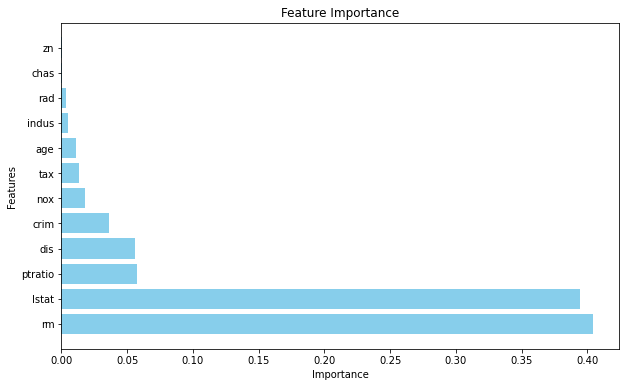

In [119]:
# Sort the feature importance values in descending order
feature_imp_b_sorted = feature_imp_b.sort_values(by='importance', ascending=False)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(feature_imp_b_sorted.index, feature_imp_b_sorted['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

Let's see which features are the most relevant in both models

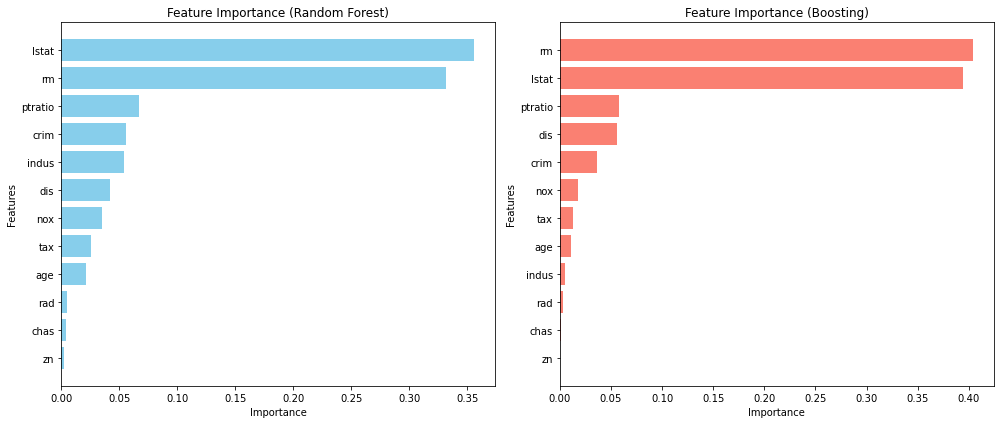

In [122]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the first graph on the first subplot (left)
ax1.barh(feature_imp_sorted.index, feature_imp_sorted['importance'], color='skyblue')
ax1.set_xlabel('Importance')
ax1.set_ylabel('Features')
ax1.set_title('Feature Importance (Random Forest)')
ax1.invert_yaxis()  # Invert the y-axis to display the most important feature at the top

# Assuming you have another DataFrame called 'feature_imp2' for the second graph
# Plot the second graph on the second subplot (right)
ax2.barh(feature_imp_b_sorted.index, feature_imp_b_sorted['importance'], color='salmon')
ax2.set_xlabel('Importance')
ax2.set_ylabel('Features')
ax2.set_title('Feature Importance (Boosting)')
ax2.invert_yaxis()  # Invert the y-axis to display the most important feature at the top

# Adjust the space between subplots
plt.tight_layout()

# Show the combined subplots
plt.show()


From the figure we observe that varaible importance ranking is similar with bagging and random forests, but there are significant differences.